<a href="https://colab.research.google.com/github/LolaLS/My_Junior_Venture/blob/main/Junior_Venture_BCWisconsinDataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **JUNIOR VENTURE PROJECT**

Project Notes:

*   Since the RSNA Kaggle dataset was too large, I switched to using a different dataset that was uploaded by the University of California, Irvine.
*   This new dataset is much smaller and includes features that have already been extracted from fine needle aspiration biopsies rather than mammograms.
*   During this kind of biopsy, fluid is removed from a cyst and analyzed for cancer cells. This dataset includes the features of these cancer cells, which can be used to predict whether or not the patient has cancer. ([Citation URL](https://www.cancer.org/cancer/types/breast-cancer/screening-tests-and-early-detection/breast-biopsy/fine-needle-aspiration-biopsy-of-the-breast.html#:~:text=During%20a%20fine%20needle%20aspiration,needle%20biopsy%20is%20often%20preferred)).

Citations:


*   Specific data sources and help/tutorials are included in the comments below.
*   Most coding help was sourced from Kaggle Learn.
*   Code explanations were sourced from Chat GPT.   
*   I also used online documentation for specific guidance while working with libraries.

Updates:


*   17-18/12/2023: So far, I have loaded in all of the data, performed various visualizations, and created a couple very basic models (Decision Tree Regressor and Random Forests Regressor).
*  21/12/2023: Changed the n_estimators parameter for the random forest to optimize the model based on trial and error. Checked for missing values and categorical variables. Used label encoder to convert categorical variables. Tried implementing a pipeline, but it wasn't working.
*  22/12/2023: Implemented a working pipeline using the same random forests model as before.
*  23/12/2023: Tried to implement cross validation. The code ran, but I must still interpret the results to determine accuracy because the cross validation score uses a differnt metric to the one I have been using thus far (MAE, which is typically used for regression).
*  26/12/2023: Finished implementing cross validation and recieved a 98.4% accuracy score with a random forests model and cv of 9. Also recieved help from Chat GPT in identiying that I was using a regressor instead of a classifier for binary classification (hence why the accuracy score metric was not working with my model).
*  28/12/2023: Implemented GridSearchCV as per Sonya's advice. Used a cited tutorial to help with the implementation and used the Scikit Learn documentation for help understanding the code. Through GSCV, I obtained a list of optimal parameters (based on the few I provided it). Then, I made a new model using these parameters that performed slightly better than the previous model, including after cross validation. In order to make the most of GridSearchCV, I should input more parameters in the param_grid so that more combinations are tested (but the accuracy is already so high that I may move on to neural networks and come back to this).
*  14/1/2024: Realized exactly why I shouldn't have been using MAE in the beginning as a loss function. MAE is usually used for regression, not classification. This is why I switched to accuracy score a while back. I also realized that I had included 'ID' in my bc_features (components of x dataset), which was actually messing with my accuracy. The 'ID' of the patient obviously has nothing to do with their diagnosis, so it does not need to be included in the x dataset. However, I thought it was interesting how in some cases, the 'ID' was dragging the accuracy down slightly (which made sense because there is no reason for it to be useful in making predictions), but in other cases (when GridSearchCV was used), the 'ID' actually made the accuracy higher. This is sort of concerning because I suppose then, to some extent, the model was actually basing some of its decisioning on the 'ID', which should not be the case. I mean, the changes in accuracy between including and excluding the feature were very low, but still. Reviewed neural networks in Kaggle Learn.

Next Steps:

*   Use different metrics of accuracy to analyze performance and results, such as a confusion matrix (check false positives/false negatives...).
*   Use more advanced models and compare outcomes.
*   Potentially look at other users models or my own and see how specific parts of the dataset may not be well diagnosed. Attempt to create a model that specifically targets these flaws.
*   Try to obtain image data and create new models.



In [94]:
! pip install -q kaggle

# SETUP HELP: https://www.youtube.com/watch?v=98xlJvuLMtI

In [ ]:
! pip install matplotlib

In [ ]:
from google.colab import files
files.upload()

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d uciml/breast-cancer-wisconsin-data --force

# ORIGINAL DATA SOURCE: https://data.world/health/breast-cancer-wisconsin
#                       https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic
# KAGGLE DATA SOURCE: https://www.kaggle.com/datasets/uciml/breast-cancer-wisconsin-data (original upload by UCI Machine Learning)

In [7]:
! unzip breast-cancer-wisconsin-data

In [103]:
# All of the necessary imports.

import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt

In [9]:
import os
if not os.path.exists("/content/breast-cancer-wisconsin-data.zip"):
    os.symlink("data.csv")

In [10]:
train_file_path = 'data.csv'
bc_data = pd.read_csv(train_file_path)

In [ ]:
bc_data.head(5) # Visualizing the first 5 rows of the dataset.

In [ ]:
bc_data.columns # Printing the names of all of the columns of the dataset.

In [ ]:
# Checking for missing values. There are none except 'Unnamed: 32'.

missing_columns = [col for col in bc_data.columns if bc_data[col].isnull().any()] # Note that the .isnull() function checks if values are missing while the .any() function checks whether there are any values that satisfy the condition.
print(missing_columns)

In [ ]:
# Checking for categorical variables. The only one is 'diagnosis', which makes sense because this uses 'M' and 'B' to identify malignant and benign cases. (Help from Chat GPT to break code down).

finding_cat_col = (bc_data.dtypes == 'object') # Finding the columns that have categorical values (M and B for diagnosis). In these cases, the data type of the column is 'object'. This is known as a boolean mask and will return true or false values for each column, depending on the type of the entries.
categorical_columns = list(finding_cat_col[finding_cat_col].index) # The finding_cat_col[finding_cat_col] line gives the columns that result in the previous statement being true.
print(categorical_columns) # Prints the name of the columns at the above indeces.

In [ ]:
# Creating an encoder to transform categorical values to numbers.

label_encoder = LabelEncoder() # Define the encoder.
label_columns = pd.DataFrame(label_encoder.fit_transform(bc_data[categorical_columns]), columns = ['diagnosis']) # Transform the categorical columns to numerical values using the encoder. Make sure that this is a dataframe with a column name of 'diagnosis' so that it can be concatenated with the other dataframe.

missing_y_bc_data = bc_data.drop(categorical_columns, axis = 1) # Drop the original categorical columns from the dataset. When axis = 1, we are dropping columns. When axis = 0, we are dropping rows.
encoded_y_bc_data = pd.concat([missing_y_bc_data, label_columns], axis=1) # Concatenate the old data minus the categorical columns with the encoded columns. Used Chat GPT to understand the axis.

encoded_y_bc_data # This will be a dataframe.

In [ ]:
# This is another way to convert the categorical diagnosis values to numbers. Don't need this because I used the label encoder above.

"""

# Models require that the y-values be floats (not strings).
# This code changes each of the letters to corresponding numbers.

for i in range(len(y)):
  if y[i] == 'M':
    y[i] = 1.0
  elif y[i] == 'B':
    y[i] = 0.0

"""

In [ ]:
# Assigning the diagnosis values to y.

original_y = bc_data.diagnosis
print("Original Diagnosis Type:", original_y.dtype) # The type used to be an object: M or B.

y = encoded_y_bc_data.diagnosis
print("Encoded Diagnosis Type:", y.dtype) # The type is now a integer: 1 (M) or 0 (B).

In [ ]:
# Counting the number of malignant and benign cases in the original dataset (categorical diagnosis values).

M_counter = 0
B_counter = 0
for i in range(len(original_y)):
  if original_y[i] == 'M':
    M_counter = M_counter + 1
  elif original_y[i] == 'B':
    B_counter = B_counter + 1

print(M_counter)
print(B_counter)

In [ ]:
# Counting the number of malignant and benign cases in the new dataset (integer diagnosis values). Comparing these values to the values found above to make sure there is consistency.

M_counter = 0
B_counter = 0
for i in range(len(y)):
  if y[i] == 1:
    M_counter = M_counter + 1
  elif y[i] == 0:
    B_counter = B_counter + 1

print(M_counter)
print(B_counter)

In [ ]:
y = pd.DataFrame(y) # Make sure that y is still a dataframe

y

In [74]:
# Selecting the basic features that will be used for model training.

bc_features = ['radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean']

In [75]:
# Assigning these features to x.

x = bc_data[bc_features]

In [ ]:
# Preforming the train-test split (80% of the data is for training while the remaining 20% is for validation).
# Checking to make sure the sizes of the data is correct.

train_x, test_x, train_y, test_y = train_test_split(x, y, train_size = 0.8, test_size = 0.2, random_state = 0) # Specifying the random_state makes sure that we get the same split each time.
print('Train Shape:', train_x.shape, train_y.shape)
print('Test Shape:', test_x.shape, test_y.shape)

In [ ]:
# Data visualizations to develop understanding of how these features may affect the diagnosis.

sns.scatterplot(bc_data, x='radius_mean', y='diagnosis')

In [ ]:
sns.scatterplot(bc_data, x='texture_mean', y='diagnosis')

In [ ]:
sns.scatterplot(bc_data, x='perimeter_mean', y='diagnosis', hue = None)

In [ ]:
sns.scatterplot(bc_data, x='area_mean', y='diagnosis')

In [ ]:
sns.scatterplot(bc_data, x='smoothness_mean', y='diagnosis')

In [ ]:
sns.scatterplot(bc_data, x='compactness_mean', y='diagnosis')

In [ ]:
sns.scatterplot(bc_data, x='concavity_mean', y='diagnosis')

In [ ]:
sns.scatterplot(bc_data, x='concave points_mean', y='diagnosis')

In [ ]:
sns.scatterplot(bc_data, x='symmetry_mean', y='diagnosis')

In [ ]:
sns.scatterplot(bc_data, x='fractal_dimension_mean', y='diagnosis')

In [ ]:
# Very basic decision tree model set up.
bc_DT_model = DecisionTreeClassifier(random_state = 1) # Again, setting the random_state to a constant ensures the same results each time.

# Fitting the model to the training data.
bc_DT_model.fit(train_x, train_y)

# Validating the model to observe accuracy. Accuracy ends up being 90.4% accuracy score (including 'ID' in bc_features). Accuracy is 92.1% (excluding 'ID').
DT_predictions = bc_DT_model.predict(test_x)
print("Accuracy Score: ", accuracy_score(test_y, DT_predictions)) # This will return the percent accuracy.

In [ ]:
# Slightly more advanced model. Performs slightly better with 93.9% accuracy score (when 'ID' is included and n_estimators is optimized using trial and error to avoid under/over-fitting). Accuracy score of 96.5% (excluding 'ID').
# At first, I was struggling to use the accuracy_score metric as the model was outputting decimals. Chat GPT helped me realize I was accidentally using a regressor and not a classifier for binary prediction!

bc_RF_model = RandomForestClassifier(n_estimators = 30, random_state = 1) # n_estimators represents the number of decision trees in the forest.
bc_RF_model.fit(train_x, train_y)
RF_predictions = bc_RF_model.predict(test_x)
print(RF_predictions)
print("Accuracy Score: ", accuracy_score(test_y, RF_predictions))

In [ ]:
# Implementing a pipeline, instead. Chat GPT helped me debug errors here (ended up adding remainder parameter and transforming categorical y-values separately). Same accuracy as the previous random forest as it is the same exact model.

num_features = train_x.columns

preprocessor = ColumnTransformer(transformers=[('num_scale', StandardScaler(), num_features)], remainder = 'passthrough') # The remainder parameter ensures that any columns that are not included in the transformers are passed through without transformation or error. The standard scaler ensures that the values are on the same scale and can be passed through models.
bc_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', bc_RF_model)])

bc_pipeline.fit(train_x, train_y)
pipeline_RF_predictions = bc_pipeline.predict(test_x)
accuracy_score(test_y, pipeline_RF_predictions)

In [ ]:
# Since this is a small dataset, we can use cross validation to increase the model's exposure to a diverse dataset. Cross validation basically splits the dataset into traning and testing groups in a number of ways and trains the model on each variation. This allows the model to be trained and tested on more data points, rather than simply trained on 80% and tested on 20%.

# cv_2_scores = cross_val_score(bc_pipeline, x, y, cv = 2)
# cv_3_scores = cross_val_score(bc_pipeline, x, y, cv = 3)
# cv_4_scores = cross_val_score(bc_pipeline, x, y, cv = 4)
# cv_5_scores = cross_val_score(bc_pipeline, x, y, cv = 5)
# cv_6_scores = cross_val_score(bc_pipeline, x, y, cv = 6)
# cv_7_scores = cross_val_score(bc_pipeline, x, y, cv = 7)
# cv_8_scores = cross_val_score(bc_pipeline, x, y, cv = 8)
cv_9_scores = cross_val_score(bc_pipeline, x, y, cv = 9)
# cv_10_scores = cross_val_score(bc_pipeline, x, y, cv = 10)
# cv_11_scores = cross_val_score(bc_pipeline, x, y, cv = 11)
# cv_12_scores = cross_val_score(bc_pipeline, x, y, cv = 12)

In [59]:
# These are the percent accuracies for each of the cross validation training sessions. Note that this is a different metric of performance compared to MAE. I tried cross validation with a number of values for cv (representing the number of groups the data is split into) and recieved different results each time, but the highest accuracy in a round occured when cv=9: 98.4%.

# print("When cv=2: ", cv_2_scores)
# print("When cv=3: ", cv_3_scores)
# print("When cv=4: ", cv_4_scores)
# print("When cv=5: ", cv_5_scores)
# print("When cv=6: ", cv_6_scores)
# print("When cv=7: ", cv_7_scores)
# print("When cv=8: ", cv_8_scores)
print("When cv=9: ", cv_9_scores)
# print("When cv=10: ", cv_10_scores)
# print("When cv=11: ", cv_11_scores)
# print("When cv=12: ", cv_12_scores)

When cv=9:  [0.96875    0.828125   0.92063492 0.93650794 0.96825397 0.96825397
 0.98412698 0.92063492 0.96825397]


In [ ]:
# Implementing GridSearchCV as per Sonya's advice. CITATION FOR GUIDANCE: https://www.kaggle.com/code/vikumsw/guide-on-hyperparameter-tuning-using-gridsearchcv.

"""
Some Definitions Based on the Output:
{'bootstrap': True, --> Regular decision trees often overfit. Bootstrapping is the process of selecting random samples of the data and creating a new tree for each of these random subsets. We then use predictions of each of the models to determine the ultimate classification through the process known as aggregation. This is the idea behind a random forest. EXPLANATION CITATION: https://medium.com/@sly.of.zero/decision-trees-bootstrap-aggregating-and-bagging-8c6cf764e689#:~:text=This%20method%20is%20used%20by,final%20results%20is%20called%20Aggregating.
 'criterion': 'gini', --> Measures the quality of a split.
 'max_depth': None, --> Maximum depth of a tree (meaning the number of nodes or "decisions").
 'max_features': 'sqrt', --> Number of features to take into account when identifying the best split.
 'n_estimators': 30, --> The number of trees in the forest.
 'min_samples_leaf': 1, --> The number of samples a node must output to a new node in order to be considered a node.
 'min_samples_split': 2,' --> The minimum number of samples a node must contain to split into multiple nodes.
"""

# Prints out the different parameters available for the random forests model.

bc_RF_model.get_params()

In [62]:
# When implementing GSCV, we must outline which parameters and which values of these parameters we would like to test in order to find the optimal model.

param_grid = {
    'bootstrap': [True],
    'max_depth': [50, 75],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [1, 2],
    'min_samples_split': [2],
    'n_estimators': [100, 500, 1000]}

In [63]:
# This is simply the scorer that we will use to measure how well each set of parameters performs in terms of the model's accuracy.

gscv_scorer = make_scorer(accuracy_score)

In [76]:
# Here, we define the model using GridSearchCV, which will check each combination of parameters and determine the best one.
# First try outputted the following (cv was set to 4):
"""
Best Parameters for Random Forest Classifier Model:  {'bootstrap': True, 'max_depth': 50, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best Score:  0.9455948980596869
"""
# Second try wasn't much better and outputted the following (cv was set to 9):
"""
Best Parameters for Random Forest Classifier Model:  {'bootstrap': True, 'max_depth': 50, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
Best Score:  0.9456845238095237 (including 'ID')
Best Score:  0.9439208553791887 (excluding 'ID')
"""

gsvc_bc_RF_model = GridSearchCV(estimator = bc_RF_model, param_grid = param_grid, n_jobs = -1, cv = 9, scoring = gscv_scorer, verbose = 2) # n-jobs refers to the number of jobs the training should run in parallel (-1 means that we are using all processors). cv refers to the n-fold cross validation (just as I used before). Verbose just refers to the messaging.
gsvc_bc_RF_model.fit(x, y)
print('Best Parameters for Random Forest Classifier Model: ', gsvc_bc_RF_model.best_params_) # Outputs the optimal parameters for the model.
print('Best Score: ', gsvc_bc_RF_model.best_score_) # Outputs the score that these parameters generated.

Fitting 9 folds for each of 24 candidates, totalling 216 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:909: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Best Parameters for Random Forest Classifier Model:  {'bootstrap': True, 'max_depth': 50, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1000}
Best Score:  0.9439208553791887


In [ ]:
# This is the training and pipeline for the improved random forests model. The model had a slightly better accuracy than the first when I included 'ID': 95.6%. However, when I excluded 'ID', the accuracy actually dropped to 93.9%.

updated_bc_RF_model = RandomForestClassifier(n_estimators = 500, max_depth = 50, min_samples_split = 2, min_samples_leaf = 1, max_features = 'auto', random_state = 1)
updated_bc_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', updated_bc_RF_model)])
updated_bc_pipeline.fit(train_x, train_y)
updated_pipeline_RF_predictions = updated_bc_pipeline.predict(test_x)
accuracy_score(test_y, updated_pipeline_RF_predictions)

In [ ]:
# Attempting cross validation on the updated model. Once again, tried out a number of different values of n.

# updated_cv_2_scores = cross_val_score(updated_bc_pipeline, x, y, cv = 2)
# updated_cv_3_scores = cross_val_score(updated_bc_pipeline, x, y, cv = 3)
# updated_cv_4_scores = cross_val_score(updated_bc_pipeline, x, y, cv = 4)
# updated_cv_5_scores = cross_val_score(updated_bc_pipeline, x, y, cv = 5)
# updated_cv_6_scores = cross_val_score(updated_bc_pipeline, x, y, cv = 6)
updated_cv_7_scores = cross_val_score(updated_bc_pipeline, x, y, cv = 7)
# updated_cv_8_scores = cross_val_score(updated_bc_pipeline, x, y, cv = 8)
# updated_cv_9_scores = cross_val_score(updated_bc_pipeline, x, y, cv = 9)
# updated_cv_10_scores = cross_val_score(updated_bc_pipeline, x, y, cv = 10)
# updated_cv_11_scores = cross_val_score(updated_bc_pipeline, x, y, cv = 11)
# updated_cv_12_scores = cross_val_score(updated_bc_pipeline, x, y, cv = 12)

In [ ]:
# Printing the accuracies for each round of cross validation on the updated model.
# Highest accuracy occured when cv=7: 98.765% (including 'ID') and 97.5 (excluding 'ID').

# print("When cv=2: ", updated_cv_2_scores)
# print("When cv=3: ", updated_cv_3_scores)
# print("When cv=4: ", updated_cv_4_scores)
# print("When cv=5: ", updated_cv_5_scores)
# print("When cv=6: ", updated_cv_6_scores)
print("When cv=7: ", updated_cv_7_scores)
# print("When cv=8: ", updated_cv_8_scores)
# print("When cv=9: ", updated_cv_9_scores)
# print("When cv=10: ", updated_cv_10_scores)
# print("When cv=11: ", updated_cv_11_scores)
# print("When cv=12: ", updated_cv_12_scores)

In [ ]:
"""
Neural Network Loss Function:
The loss function (MAE) used for regression can not be used for classification. This is because MAE measures how far away the predicted targets are from the actual targets. For this, numerical predictions are necessary.
For classification, we use accuracy, which is the ratio of correct predictions to all predictions.
However, for the neural network loss function, we need to calculate changes smoothly. A loss function does this for us because it measures how wrong or how right ar predictions are. On the other hand, accuracy simply measures if we were correct or incorrect.
Thus, for neural network binary classification problems, we use cross-entropy, whcih essentially compares the predictions to the actual values through probability distributions.
For example, the correct classification should be true with a 1.0 probability. However, our model may only predict the right answer with a 0.6 probability. Thus, the loss is 0.4.
Note that the sigmoid activation can convert these probailities to binary predictions.
"""
NN_model = keras.Sequential([ # Chat GPT helped me understand the first dense layer parameter.
    layers.BatchNormalization(), # Scaling the data onto common scale.
    layers.Dense(10, activation='relu', input_shape=[10]), # ReLu is simply an activation function that sets any negative values to 0.
    layers.Dropout(0.3), # Avoiding overfitting by dropping out some inputs.
    layers.Dense(10, activation='relu'),
    layers.Dropout(0.3), # Avoiding overfitting by dropping out some inputs.
    layers.Dense(7, activation='relu'),
    layers.Dropout(0.3), # Avoiding overfitting by dropping out some inputs.
    layers.Dense(7, activation='relu'),
    layers.Dropout(0.3), # Avoiding overfitting by dropping out some inputs.
    layers.Dense(5, activation='relu'),
    layers.Dropout(0.3), # Avoiding overfitting by dropping out some inputs.
    layers.Dense(5, activation='relu'),
    layers.Dense(1, activation='sigmoid'), # Sigmoid is an activation function that takes a probability and sets it to a binary classification of 1 or 0.
])

NN_model.compile(
    optimizer='adam',
    loss='binary_crossentropy', # This is used to measure the loss of the model as it trains. (Reasoning above).
    metrics=['binary_accuracy'] # This is used to measure the accuracy.
)

history = NN_model.fit(
    train_x, train_y,
    validation_data=[test_x, test_y],
    batch_size=32,
    epochs=200,
    verbose=1
)

In [ ]:
# Chat GPT helped me break down this code.

history_df = pd.DataFrame(history.history) # The data from the neural network's training history is put in a data frame.
history_df.head()

Minimum training loss:  0.18535441160202026
Minimum validation loss:  0.14673273265361786


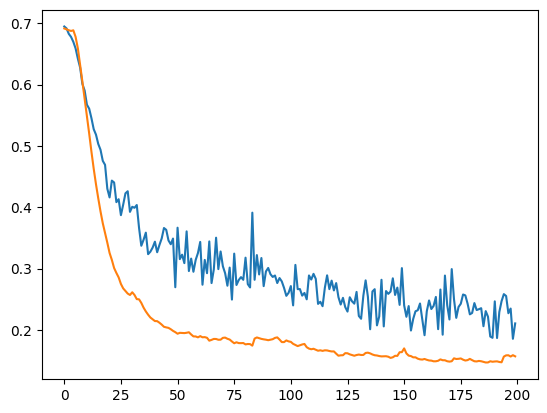

In [149]:
# Chat GPT helped me break down this code.
# CITATION CODE SYNTAX HELP: https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/

plt.plot(history_df.loc[:, ['loss', 'val_loss']]) # The : selects all of the rows (all of the epochs).
print("Minimum training loss: ", history_df['loss'].min()) # Including both to check for over/under fitting.
print("Minimum validation loss: ", history_df['val_loss'].min())

Maximum training accuracy:  0.9450549483299255
Maximum validation accuracy:  0.9649122953414917


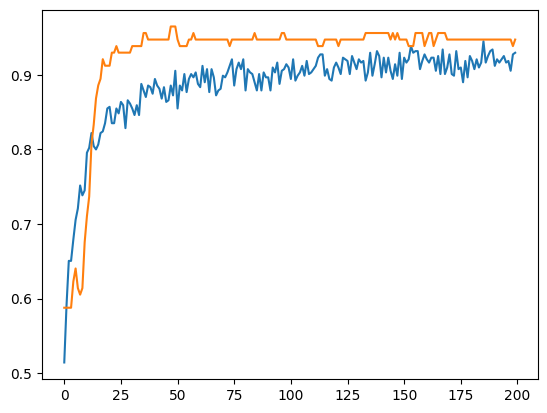

In [150]:
plt.plot(history_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']]) # The : selects all of the rows (all of the epochs).
print("Maximum training accuracy: ", history_df['binary_accuracy'].max()) # Including both to check for over/under fitting.
print("Maximum validation accuracy: ", history_df['val_binary_accuracy'].max())